In [1]:
# !pip install bert-for-tf2

In [1]:
# https://www.kaggle.com/sushanth1995/text-classification-with-bert-xgboost
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from tqdm import tqdm
# from keras.models import Sequential
# from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
# from keras.initializers import Constant
# from keras.optimizers import Adam
# from keras import regularizers
# import keras.backend as K

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.backend as K

import tensorflow_hub as hub

try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert



In [2]:
tf.__version__

'2.3.0'

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
value = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print ('***If TF can access GPU: ***\n\n',value) # MUST RETURN True IF IT CAN!!

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
***If TF can access GPU: ***

 False


In [5]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
pathMain = r'/content/drive/MyDrive/colab/Tbrain/data/'
pathMain = r'./data/'
train= pd.read_csv(os.path.join(pathMain,'trainset_proc2.csv'))
test= pd.read_csv(os.path.join(pathMain,'testset_proc2.csv'))
test.set_index(test['Id'],inplace=True)

In [7]:
train.columns

Index(['Title', 'Abstract', 'Classifications', 'Abstract_proc', 'Title_proc',
       'OTHERS', 'ENGINEERING', 'EMPIRICAL', 'THEORETICAL',
       'Title_Abstract_proc'],
      dtype='object')

# EDA

In [8]:
if len(set(train.loc[train.OTHERS==1,'Classifications'] )) ==1: print('!!!! OTRHER CLASSIFICATION IS UNIQUE')
print('and',train.loc[train.OTHERS==1,'Classifications'])

!!!! OTRHER CLASSIFICATION IS UNIQUE
and 13      OTHERS
32      OTHERS
34      OTHERS
43      OTHERS
51      OTHERS
         ...  
6904    OTHERS
6941    OTHERS
6960    OTHERS
6961    OTHERS
6991    OTHERS
Name: Classifications, Length: 259, dtype: object


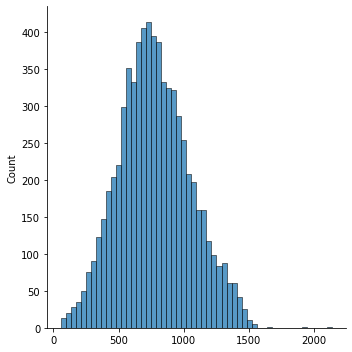

In [9]:
import seaborn as sns
sns.displot(np.array([len(s) for s in train.Abstract_proc]))

In [10]:
train['Abstract_proc'][5].count('paper')

0

In [11]:
test['Title_Abstract_proc'] 


Id
1        efficient visual coding retina v human visual ...
2        polymorph increasing p spelling efficiency sel...
3        cooperative cognitive networks optimal distrib...
4        indoor occupancy estimation carbon dioxide con...
5        lower bound general circuits computing clique ...
                               ...                        
39996    structure recognition leaf powers galled phylo...
39997    extended report implicit calculus generic prog...
39998    congusto htcondor graphical unified supervisin...
39999    protein folding hexagonal prism lattice diagon...
40000    modelling temporal information discrete fourie...
Name: Title_Abstract_proc, Length: 40000, dtype: object

In [12]:
test['Title_Abstract_proc'] 

Id
1        efficient visual coding retina v human visual ...
2        polymorph increasing p spelling efficiency sel...
3        cooperative cognitive networks optimal distrib...
4        indoor occupancy estimation carbon dioxide con...
5        lower bound general circuits computing clique ...
                               ...                        
39996    structure recognition leaf powers galled phylo...
39997    extended report implicit calculus generic prog...
39998    congusto htcondor graphical unified supervisin...
39999    protein folding hexagonal prism lattice diagon...
40000    modelling temporal information discrete fourie...
Name: Title_Abstract_proc, Length: 40000, dtype: object

In [13]:
trainSet = set([w for s in train['Title_Abstract_proc'] for w in s.split(' ')])
testSet = set([w for s in test['Title_Abstract_proc'] for w in s.split(' ')])

In [14]:
wordSetOnlyInTest = testSet - trainSet

In [15]:
def removeWordOnlyInTest(text):
    return ' '.join([word for word in text.split(' ') if word not in wordSetOnlyInTest])

train['Abstract_proc'] = train['Abstract_proc'].apply(removeWordOnlyInTest )

In [16]:
train.Title_Abstract_proc

0       distinctiveness complexity repeatability onlin...
1       adaptable fast matrix multiplication algorithm...
2       trimming multipath efficient dynamic routing m...
3       learning word embeddings speech paper propose ...
4       unified model near remote sensing propose nove...
                              ...                        
6995    small vulnerable sets determine large network ...
6996    emergence humancomparable balancing behaviors ...
6997    neural paraphrase generation stacked residual ...
6998    efficient twitter sentiment classification sub...
6999    energy efficient barring factor enabled extend...
Name: Title_Abstract_proc, Length: 7000, dtype: object

In [17]:
import gc

del wordSetOnlyInTest

gc.collect()

221

# BERT Encodings

In [18]:
max_len = 120

In [22]:
"""BERT Methods Predefined"""
def bert_encode(texts, tokenizer, max_len=max_len):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [23]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7000 rows and 10 columns in train
There are 40000 rows and 6 columns in test


In [26]:
os.getcwd()

'D:\\PyData\\github\\Tbtrain-MachineReadRecord'

In [69]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
# module_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
# module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [70]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocab_file, do_lower_case)

In [71]:
full_input = bert_encode(train['Title_Abstract_proc'].values, tokenizer, max_len=max_len)

In [72]:
full_labels = train['Classifications'].values.copy()
full_labels = train[['THEORETICAL','ENGINEERING','EMPIRICAL','OTHERS']].values.copy()


In [73]:
train_data, val_data, train_labels, val_labels = train_test_split(train['Title_Abstract_proc'].values,
                                                                  full_labels,
                                                                  test_size=0.15, random_state=42)

In [74]:
train_input = bert_encode(train_data, tokenizer, max_len=max_len)
val_input = bert_encode(val_data, tokenizer, max_len=max_len)
test_input = bert_encode(test['Title_Abstract_proc'].values, tokenizer, max_len=max_len)

In [75]:
tokenizer.tokenize('this')
tokenizer.convert_tokens_to_ids(['this', 'is', 'a', 'pen'])

[2023, 2003, 1037, 7279]

# Build Bert model

In [76]:
learning_rate=1e-5
decay=5e-5
max_len=max_len
Dropout_num = 0.25
lr_schedule = [9e-7,1e-8,5e-8,9e-8,7e-9,1e-9]
K.clear_session()

In [83]:
def mymodel():
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]

    out = Dropout(Dropout_num)(clf_output)
    out = Dense(8, activation='relu', activity_regularizer=regularizers.l2(1e-5))(out)

    # out = clf_output
    num_classes = 1#full_labels.shape[1]#len(set(full_labels))
    out = Dense(num_classes, activation='sigmoid')(clf_output)

    ## Type4
    # out = clf_output
    sBERT = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    # sBERT.compile(SGD(lr=learning_rate, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy',f1_m])

    sBERT.compile(Adam(lr=learning_rate, decay=decay), loss='binary_crossentropy', metrics=['accuracy',f1_m])#CategoricalCrossentropy # 'accuracy',
    sBERT.summary()

    return sBERT

In [84]:
# init_weights = sBERT.get_weights()

In [85]:
checkpoint1 = ModelCheckpoint('./model/best_val_f1_m.h5',
                             monitor='val_f1_m',
                             mode='max',
                             save_best_only=True)

In [86]:
# # train_input, val_input,test_input, train_labels, val_labels, full_labels
# train_history = sBERT.fit(
#     train_input, np.array(train_labels[:,0]),
#     epochs = 5,
#     batch_size = 8,
#     validation_data=(val_input, np.array(val_labels[:,0])),
#     callbacks=[checkpoint1]
# )

In [ ]:
list_sBERT=[]
list_train_history = []


for i in range(4):
    print('='*5,i,'='*5)

    sBERT = mymodel()


    train_history = sBERT.fit(
        train_input, np.array(train_labels[:,i]),
        epochs = 5,
        batch_size = 8,
        validation_data=(val_input, np.array(val_labels[:,i])),
        callbacks=[checkpoint1]
    )

    list_sBERT.append(sBERT)
    list_train_history.append(train_history)


===== 0 =====
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 120)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_ma

# New Section

In [ ]:
sBERT.load_weights('./model/best_val_f1_m.h5')

In [ ]:
bert_encoder = Model(sBERT.inputs, sBERT.layers[-4].output)
bert_encoder.summary()

In [ ]:
%%time
train_embed = bert_encoder.predict(train_input)
test_embed = bert_encoder.predict(test_input)

In [ ]:
train_embed

In [ ]:
test_embed

In [ ]:
import pickle
with open('Train BERT 1024d Embed', 'ab') as fo:     
    pickle.dump(train_embed, fo)    

with open('Test BERT 1024d Embed', 'ab') as fo:     
    pickle.dump(test_embed, fo)  

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.svm import SVC

In [ ]:
%%time
ary_result = np.zeros((test_embed.shape[0],4))
for i in range(4):
  print(i)
  svc_model = SVC(gamma='scale', kernel='rbf', C=3)
  svc_model.fit(train_embed, train_labels[:,0])
  y_hat = svc_model.predict(test_embed)

  ary_result[:,i] = y_hat

In [ ]:
# 'EMPIRICAL', 'ENGINEERING', 'THEORETICAL', 'OTHERS'
df_sub['EMPIRICAL'] = ary_result[:,0]
df_sub['ENGINEERING'] = ary_result[:,1]
df_sub['THEORETICAL'] = ary_result[:,2]
df_sub['OTHERS'] = ary_result[:,3]

In [ ]:
df_sub.head()

In [ ]:
df_sub.to_csv('bert_SVC_v2.csv')

In [ ]:
df_sub = pd.read_csv(os.path.join(pathMain,'sample_submission.csv'))

In [ ]:
import xgboost as xgb

In [ ]:
%%time
ary_result = np.zeros((test_embed.shape[0],4))
for i in range(4):
  print(i)
  clf = xgb.XGBClassifier(max_depth=200, n_estimators=400, subsample=1, learning_rate=0.07, reg_lambda=0.1, reg_alpha=0.1, gamma=1)
  clf.fit(train_embed, train_labels[:,i])

  predictions = clf.predict(train_embed)
  print ("Training set f1_score :", np.round(f1_score(train_labels[:,i], predictions),5))
  y_hat = svc_model.predict(test_embed)
  ary_result[:,i] = y_hat

In [ ]:
df_sub = pd.read_csv(os.path.join(pathMain,'sample_submission.csv'))

# 'EMPIRICAL', 'ENGINEERING', 'THEORETICAL', 'OTHERS'
df_sub['EMPIRICAL'] = ary_result[:,0]
df_sub['ENGINEERING'] = ary_result[:,1]
df_sub['THEORETICAL'] = ary_result[:,2]
df_sub['OTHERS'] = ary_result[:,3]
df_sub.head()

df_sub.to_csv('bert_xgb_v3.csv')

In [ ]:
df_sub